In [1]:
import sys  
sys.path.insert(1, 'functions/')
from ipynb.fs.full.statistics_functions import *
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
import cartopy.crs as ccrs

# Analyzing the Weekly Data, Comparing different DoG Thresholds

In [2]:
base_path  = '/work/bk1377/a270230/'
path_ds    = base_path + 'lkf_datasets/weekly_data/'
path_ice   = base_path + 'interpolated_fesom_output/'

files = os.listdir(path_ds)
files.sort()
files.remove('.ipynb_checkpoints')
files

['ds_2013_d0.01.npy',
 'ds_2013_d0.05.npy',
 'ds_2013_d0.1.npy',
 'ds_2013_d0.2.npy',
 'ds_2013_d0.25.npy',
 'ds_2013_d0.5.npy',
 'ds_2013_d1.0.npy']

In [3]:
years = []
dogs = []
for file in files:
    years.append(file.split('_')[1].split('.')[0])
    dogs.append(file.split('_')[2][1:-4])

In [4]:
# calculate the total ice area (in km2) at every time step
ice_coverage = [[] for _ in range(len(years))]
ice_coverage_weekly = [[] for _ in range(len(years))]
for ind, year in enumerate(years):
    ice_file = path_ice + f'ice_{year}.nc'
    data = xr.open_dataset(ice_file)
    
    for day in range(len(data.time)):
        ice_coverage[ind].append(np.nansum(data.A.isel(time=day)) * 4.45**2) 
        
    ice_coverage_weekly[ind] = ice_coverage[ind][::7]

In [5]:
# get the lkf_data objects
datasets = []
for file in files:
    datasets.append(np.load(path_ds + file, allow_pickle=True)[0])

In [6]:
# get the lkf data for every timestep
lkfs_all = []
for lkf_data in datasets:
    lkfs_all.append(get_lkfs_all(lkf_data))

In [7]:
# get the number of lkfs at each timestep
n_lkfs = []
for lkfs_all_dataset in lkfs_all:
    n_lkfs.append(get_n_lkfs(lkfs_all_dataset))
    
# get the number of lkfs per ice covered area at every timestep
lkf_density = [[] for _ in years]
for year in range(len(years)):
    lkf_density[year] = np.array(n_lkfs[year]) / np.array(ice_coverage_weekly[year])

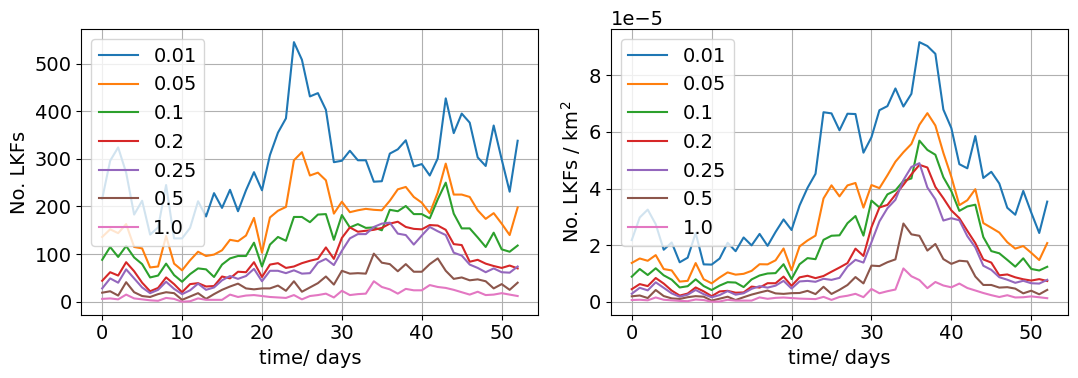

In [8]:
# plot the total number of LKFs and the number of LKFs per ice covered area 

fig, axs = plt.subplots(1,2, figsize=(11,4))

for year, dog, num_lkfs, rho_lkfs in zip(years, dogs, n_lkfs, lkf_density):
    axs[0].plot(num_lkfs, label=dog)
    axs[1].plot(rho_lkfs, label=dog)

    
ylabels = ['No. LKFs', 'No. LKFs / km$^2$']
for ind, ax in enumerate(axs):
    ax.set_ylabel(ylabels[ind])
    ax.set_xlabel('time/ days')
    ax.legend(loc='upper left')
    ax.grid()

fig.tight_layout()

In [9]:
# get the length of every LKF as well as the average
# LKF length in pixels at every timestep
lkf_len = []
av_lkf_len = []
for lkfs_all_dataset in lkfs_all:
    lkf_len.append(get_lkf_len(lkfs_all_dataset)[0])
    av_lkf_len.append(get_lkf_len(lkfs_all_dataset)[1])

/home/a/a270230/miniconda3/envs/lkf_tools/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/a/a270230/miniconda3/envs/lkf_tools/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Text(0.5, 1.0, 'dog_thres = 0.05')

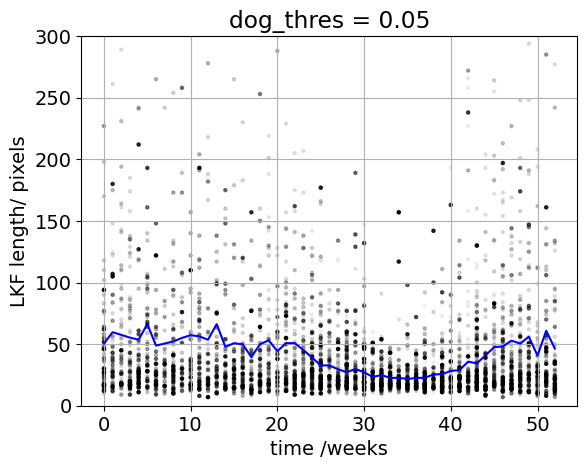

In [10]:
ind = 1
lkf_len_dataset = lkf_len[ind]
av_lkf_len_dataset = av_lkf_len[ind]

for timestep, lkf_len_timestep in enumerate(lkf_len_dataset):

    frequency = np.zeros(int(np.max(lkf_len_timestep)+1))
    for lkf_len_i in lkf_len_timestep:
        frequency[lkf_len_i] += 1
    
    f_norm = frequency/frequency.max()
    
    plt.scatter(timestep * np.ones_like(lkf_len_timestep), lkf_len_timestep, s=5, c='k', alpha=f_norm)
plt.plot(av_lkf_len_dataset, 'b')
plt.grid()
plt.ylim([0,300])
plt.ylabel('LKF length/ pixels')
plt.xlabel('time /weeks')
plt.title(f'dog_thres = {dogs[ind]}')

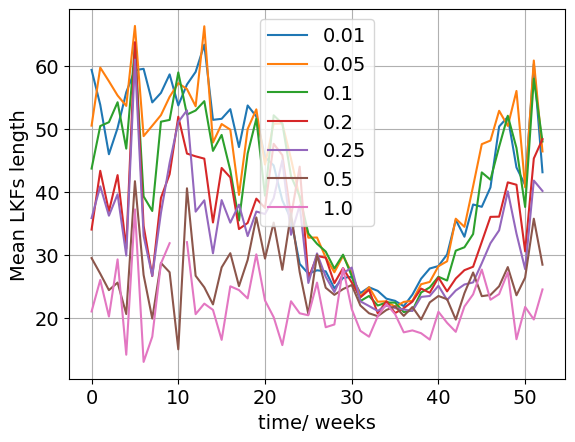

In [11]:
for dog, lkf_len in zip(dogs, av_lkf_len):
    plt.plot(lkf_len, label=dog)
    
plt.grid()
plt.xlabel('time/ weeks')
plt.ylabel('Mean LKFs length')
plt.legend()

# Analyzing the Daily Data over Multiple Years

In [13]:
base_path  = '/work/bk1377/a270230/'
path_ds    = base_path + 'lkf_datasets/daily_data/'
path_ice   = base_path + 'interpolated_fesom_output/'

files = os.listdir(path_ds)
files.sort()
files.remove('.ipynb_checkpoints')
files.remove('fesom_ifs')
files

['ds_2013.npy', 'ds_2014.npy', 'ds_2015.npy', 'ds_2016.npy', 'ds_2020.npy']

In [14]:
files = [f'ds_{i}.npy' for i in [2013, 2016]]

In [15]:
years = []
for file in files:
    years.append(file.split('_')[1].split('.')[0])

In [16]:
# calculate the total ice area (in km2) at every time step
ice_coverage = [[] for _ in range(len(years))]
ice_coverage_weekly = [[] for _ in range(len(years))]
for ind, year in enumerate(years):
    ice_file = path_ice + f'ice_{year}.nc'
    data = xr.open_dataset(ice_file)
    
    for day in range(len(data.time)):
        ice_coverage[ind].append(np.nansum(data.A.isel(time=day)) * 4.45**2) 
        
    ice_coverage_weekly[ind] = ice_coverage[ind][::7]

In [17]:
# get the lkf_data objects
datasets = []
for file in files:
    datasets.append(np.load(path_ds + file, allow_pickle=True)[0])

In [18]:
# get the lkf data for every timestep
lkfs_all = []
for lkf_data in datasets:
    lkfs_all.append(get_lkfs_all(lkf_data))

In [19]:
# get the number of lkfs at each timestep
n_lkfs = []
for lkfs_all_dataset in lkfs_all:
    n_lkfs.append(get_n_lkfs(lkfs_all_dataset))
    
# get the number of lkfs per ice covered area at every timestep
lkf_density = [[] for _ in years]
for year in range(len(years)):
    lkf_density[year] = np.array(n_lkfs[year]) / np.array(ice_coverage[year])

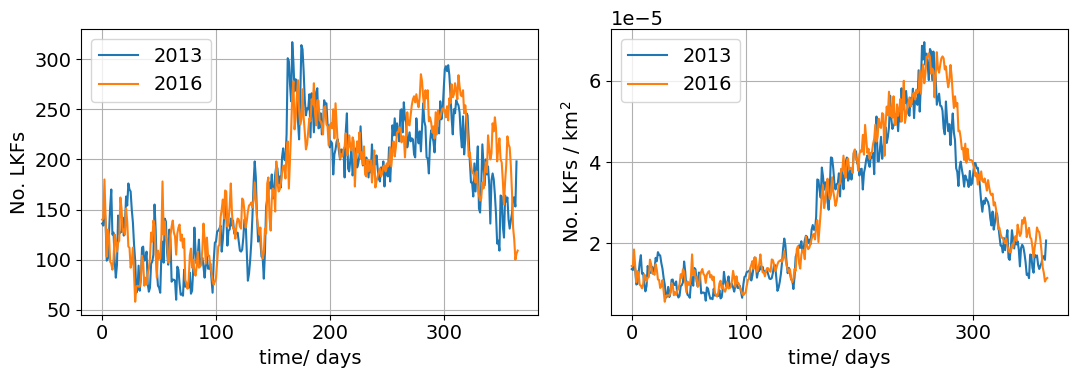

In [20]:
# plot the total number of LKFs and the number of LKFs per ice covered area 

fig, axs = plt.subplots(1,2, figsize=(11,4))

for year, num_lkfs, rho_lkfs in zip(years, n_lkfs, lkf_density):
    axs[0].plot(num_lkfs, label=year)
    axs[1].plot(rho_lkfs, label=year)

    
ylabels = ['No. LKFs', 'No. LKFs / km$^2$']
for ind, ax in enumerate(axs):
    ax.set_ylabel(ylabels[ind])
    ax.set_xlabel('time/ days')
    ax.legend(loc='upper left')
    ax.grid()

fig.tight_layout()

In [21]:
# get the length of every LKF as well as the average
# LKF length in pixels at every timestep
lkf_len = []
av_lkf_len = []
for lkfs_all_dataset in lkfs_all:
    lkf_len.append(get_lkf_len(lkfs_all_dataset)[0])
    av_lkf_len.append(get_lkf_len(lkfs_all_dataset)[1])

Text(0.5, 1.0, '2016')

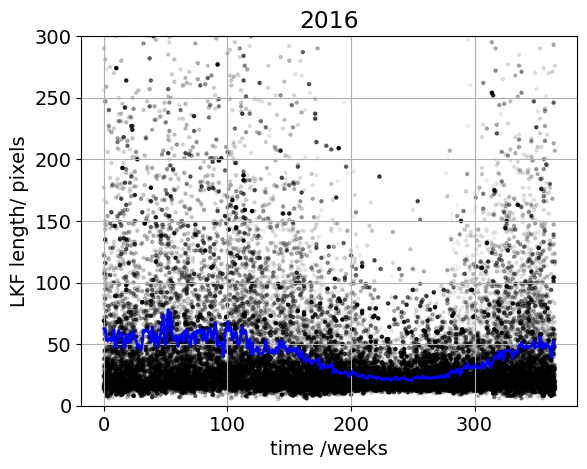

In [22]:
ind = 1
lkf_len_dataset = lkf_len[ind]
av_lkf_len_dataset = av_lkf_len[ind]

for timestep, lkf_len_timestep in enumerate(lkf_len_dataset):

    frequency = np.zeros(int(np.max(lkf_len_timestep)+1))
    for lkf_len_i in lkf_len_timestep:
        frequency[lkf_len_i] += 1
    
    f_norm = frequency/frequency.max()
    
    plt.scatter(timestep * np.ones_like(lkf_len_timestep), lkf_len_timestep, s=5, c='k', alpha=f_norm)
plt.plot(av_lkf_len_dataset, 'b', linewidth=2)
plt.grid()
plt.ylim([0,300])
plt.ylabel('LKF length/ pixels')
plt.xlabel('time /weeks')
plt.title(f'{years[ind]}')

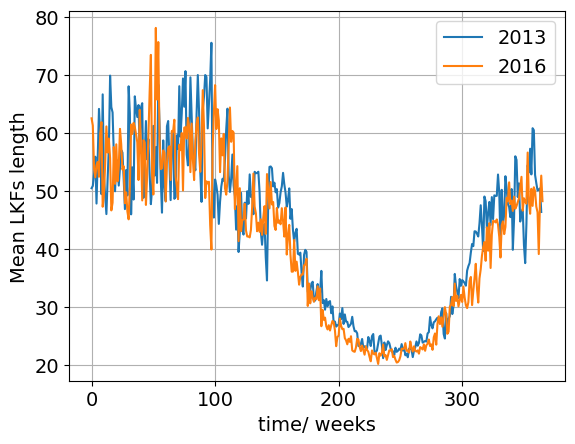

In [23]:
for year, lkf_len in zip(years, av_lkf_len):
    plt.plot(lkf_len, label=year)
    
plt.grid()
plt.xlabel('time/ weeks')
plt.ylabel('Mean LKFs length')
plt.legend()

In [24]:
# get the tracks for every timestep
tracks_all = []
for lkf_data in datasets:
    tracks_all.append(get_tracks_all(lkf_data))

In [25]:
# show the first matching pairs at each day
tracks_all_dataset = tracks_all[0]
print('\n'.join(['   \t'.join([str(tracks_all_dataset[day][lkf]).replace('[ ','[').replace('[ ','[') for day in range(7)]) for lkf in range(10)]))

[0 0]   	[0 1]   	[1 0]   	[0 0]   	[0 94]   	[1 21]   	[0 0]
[0 7]   	[4 7]   	[1 6]   	[7 5]   	[1 1]   	[1 28]   	[1 2]
[1 2]   	[5 141]   	[9 10]   	[8 1]   	[2 4]   	[4 1]   	[2 3]
[7 15]   	[6 5]   	[10 13]   	[10 26]   	[7 13]   	[7 116]   	[2 8]
[9 4]   	[7 1]   	[11 127]   	[16 17]   	[15 97]   	[14 12]   	[2 23]
[11 17]   	[13 12]   	[13 16]   	[18 96]   	[21 25]   	[22 23]   	[8 135]
[12 19]   	[14 11]   	[13 19]   	[20 27]   	[22 23]   	[23 23]   	[11 14]
[18 21]   	[15  9]   	[17 20]   	[21 28]   	[26  7]   	[24  2]   	[14 19]
[21 22]   	[16  2]   	[18 21]   	[29 35]   	[28 30]   	[25 24]   	[15 22]
[23 28]   	[19 14]   	[22 23]   	[33 40]   	[31 35]   	[28 16]   	[15 151]


In [26]:
# get the lkf paths starting at each timestep
lkf_paths = []
for lkfs_all_dataset, tracks_all_dataset in zip(lkfs_all, tracks_all):
    lkf_paths.append(get_lkf_paths(lkfs_all_dataset, tracks_all_dataset))

In [27]:
# get the lifetime of the lkf paths and their mean as well as
# the mean of only the paths that are longer than one day
lifetimes, mean_lifetime, mean_lifetime_tracked_lkfs = [], [], []
for lkf_paths_dataset in lkf_paths:
    a, b, c = get_lifetimes(lkf_paths_dataset)
    lifetimes.append(a)
    mean_lifetime.append(b)
    mean_lifetime_tracked_lkfs.append(c)

Text(0.5, 1.0, '2013')

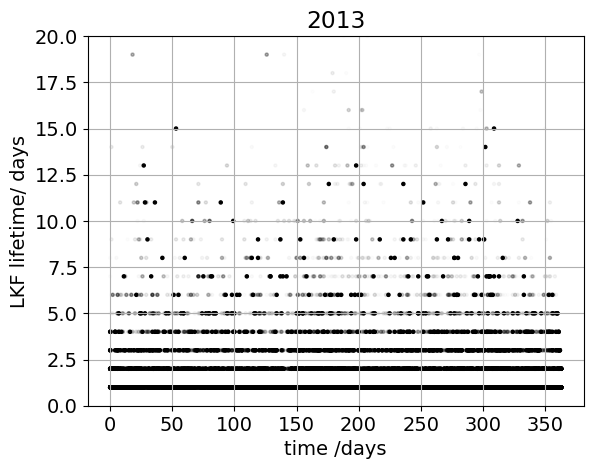

In [29]:
ind = 0
lifetimes_dataset = lifetimes[ind]
mean_lifetime_tracked_dataset = mean_lifetime_tracked_lkfs[ind]

for timestep, lifetimes_timestep in enumerate(lifetimes_dataset[:-1]):

    frequency = np.zeros(int(np.max(lifetimes_timestep)+1))
    for lifetime_lkf in lifetimes_timestep:
        frequency[lifetime_lkf] += 1
    
    f_norm = frequency/frequency.max()
    
    plt.scatter(timestep * np.ones_like(lifetimes_timestep), lifetimes_timestep, s=5, c='k', alpha=f_norm)
#plt.plot(mean_lifetime_dataset, 'b', linewidth=2)
plt.grid()
plt.ylim([0,20])
plt.ylabel('LKF lifetime/ days')
plt.xlabel('time /days')
plt.title(f'{years[ind]}')

In [30]:
# these are the lkf paths (of dataset[0]) that start at day 2. if a path starts
# already at day 1, it is not included here (only in lkf_paths[0][0])
lkf_paths[0][1]

array([1, 3, array([  5, 141]), array([6, 5]),
       array([ 7,  1,  0,  0, 94,  0,  0,  0,  0]), 8, 9, 10, 11, 12,
       array([ 14,  11, 127,   9]), array([16,  2]), 18, 20,
       array([23, 13, 16, 17]), 24, array([25,  2]),
       array([26, 17, 20, 27]),
       array([ 27,  18,  21,  28,  30,  31,  37,  35,  32,  39,  35,  34,  36,
              142])                                                           ,
       array([29, 19]), 31, 32, array([34, 31]), 35, 36, array([37, 32]),
       39, 41, 42, 43, array([45, 48]), array([46, 49]), array([47, 47]),
       array([48, 46]), 49, 50, 51, 52, array([53, 45]), 54,
       array([55, 57, 28]), 56, 59, 61, 63, 66, 67, 71, 72, 77, 78, 79,
       80, 81, array([82, 87, 66]), 83, 84, 85, 87, 89, array([ 91, 151]),
       93, 94, 99, 100, 101, array([105, 123]), array([107, 129]), 109,
       111, 112, 113, 115, 116, array([118, 136, 126,  91,  81]), 119,
       121, 125, 126, array([127, 140,  85]),
       array([128, 118, 134,  66,